In [3]:
import sys
sys.path.append("/Users/shin/work/deep/keras/pix2pix")

In [5]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense,Reshape, Input,merge
from keras.layers.merge import concatenate
from keras.layers.core import Activation, Dropout, Flatten,Lambda
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D,Conv2D, MaxPooling2D,Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from math import ceil
from PIL import Image
import matplotlib.pyplot as plt
from facade_dataset2 import load_dataset
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

In [6]:
train_d = load_dataset(dataDir = "../dataset/base/", data_range=(1,300))

load dataset start
     from: ../dataset/base/
load dataset done


In [7]:
def CBR(ch,shape,bn=True,sample='down',activation=LeakyReLU, dropout=False):
    model = Sequential()
    if sample=='down':
        model.add(Conv2D(filters=ch, kernel_size=(4,4), strides=2, padding='same',input_shape=shape))
    else:
        model.add(Conv2DTranspose(filters=ch, kernel_size=(4,4), strides=2, padding='same',input_shape=shape))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(0.5))
    if activation == LeakyReLU:
        model.add(LeakyReLU(alpha=0.2))
    else:
        model.add(Activation('relu'))
    
    return model

In [27]:
def PatchGan(patch_size=4):
    p = patch_size
    input1 = Input(shape=(p,p,12))
    input2 = Input(shape=(p,p,3))
    x1 = CBR(32,(p,p,12))(input1)
    x2 = CBR(32,(p,p,3))(input2)
    x = concatenate([x1,x2])
    x = CBR(128,(int(p/2),int(p/2),64))(x)
    x = CBR(256,(int(int(p/2)/2),int(int(p/2)/2),128))(x)
    x = Flatten()(x)
    output = Dense(1,activation='sigmoid')(x)
    model = Model(inputs=[input1,input2], outputs=output)
    return model

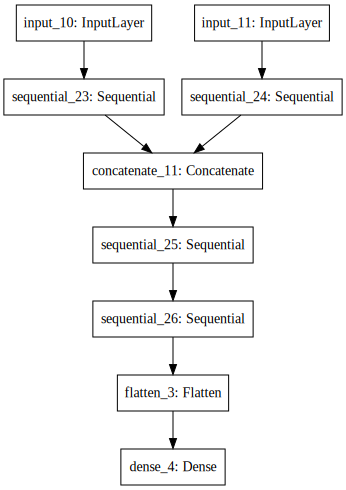

In [28]:
model = PatchGan(4)
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [29]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_10 (InputLayer)            (None, 4, 4, 12)      0                                            
____________________________________________________________________________________________________
input_11 (InputLayer)            (None, 4, 4, 3)       0                                            
____________________________________________________________________________________________________
sequential_23 (Sequential)       (None, 2, 2, 32)      6304        input_10[0][0]                   
____________________________________________________________________________________________________
sequential_24 (Sequential)       (None, 2, 2, 32)      1696        input_11[0][0]                   
___________________________________________________________________________________________

In [30]:
def discriminator(patch_size=4):
    h = 256
    w = 256
    ph = patch_size
    pw = patch_size
    gen_output = Input(shape=(h,w,3))
    label_input = Input(shape=(h,w,12))
    list_row_idx = [(i * ph, (i + 1) * ph) for i in range(int(h / ph))]
    list_col_idx = [(i * pw, (i + 1) * pw) for i in range(int(w / pw))]
    pg = PatchGan(patch_size)
    pg_list = []
    
    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            gen_patch =  Lambda(lambda x: x[:,row_idx[0]:row_idx[1],col_idx[0]:col_idx[1],:])(gen_output)
            img_patch =  Lambda(lambda x: x[:,row_idx[0]:row_idx[1],col_idx[0]:col_idx[1],:])(label_input)
            x = pg([img_patch,gen_patch])
            pg_list.append(x)
    x = concatenate(pg_list)
    output = Dense(1,activation = 'sigmoid')(x)
    model = Model(inputs =[label_input,gen_output], outputs = output)
    
    return model

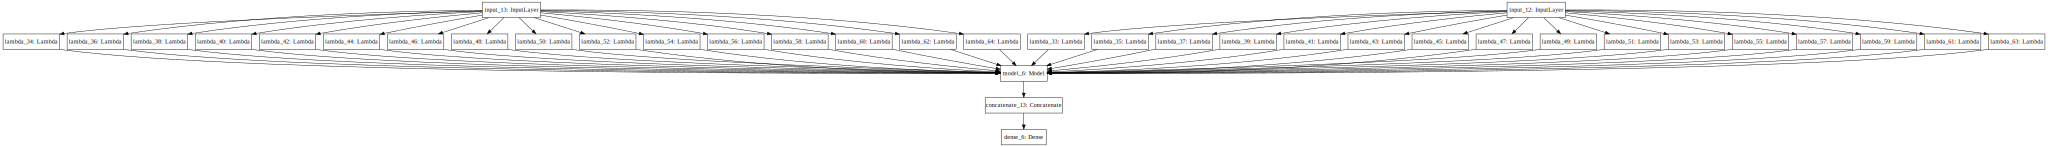

In [31]:
dis = discriminator(patch_size=64)
SVG(model_to_dot(dis).create(prog='dot', format='svg'))

In [13]:
dis.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
lambda_2 (Lambda)                (None, 64, 64, 1)     0           input_4[0][0]                    
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 64, 64, 3)     0           input_3[0][0]                    
___________________________________________________________________________________________

In [32]:
def generator():
    
    # encoder
    input1 = Input(shape=(256,256,12))
    enc_1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same',input_shape=(256,256,1))(input1)
    enc_2 = CBR(128,(256,256,64))(enc_1)
    enc_3 = CBR(256,(128,128,128))(enc_2)
    enc_4 = CBR(512,(64,64,256))(enc_3)
    enc_5 = CBR(512,(32,32,512))(enc_4)
    enc_6 = CBR(512,(16,16,512))(enc_5)
    enc_7 = CBR(512,(8,8,512))(enc_6)
    enc_8 = CBR(512,(4,4,512))(enc_7)
    
    # decoder
    x = CBR(512,(2,2,512),sample='up',activation='relu',dropout=True)(enc_8)
    x = CBR(512,(4,4,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_7]))
    x = CBR(512,(8,8,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_6]))
    x = CBR(512,(16,16,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_5]))
    x = CBR(256,(32,32,1024),sample='up',activation='relu',dropout=True)(concatenate([x,enc_4]))
    
    x = CBR(128,(64,64,512),sample='up',activation='relu',dropout=True)(concatenate([x,enc_3]))
    x = CBR(64,(128,128,256),sample='up',activation='relu',dropout=True)(concatenate([x,enc_2]))
    output = Conv2D(filters=3, kernel_size=(3,3),strides=1,padding="same")(concatenate([x,enc_1]))
     
    model = Model(inputs=input1, outputs=output)
    return(model)

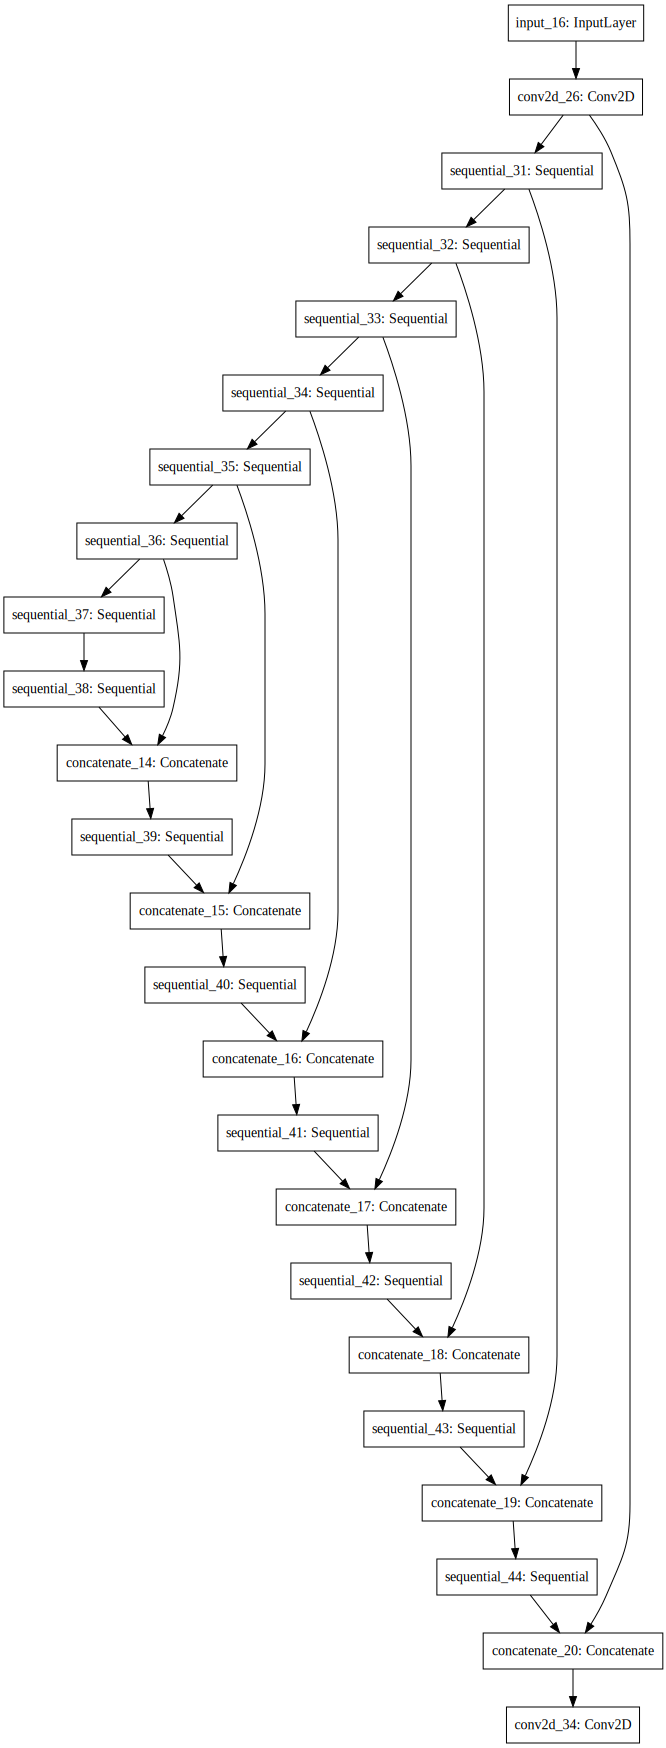

In [33]:
gen = generator()
SVG(model_to_dot(gen).create(prog='dot', format='svg'))

In [16]:
gen.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 256, 256, 1)   0                                            
____________________________________________________________________________________________________
conv2d_9 (Conv2D)                (None, 256, 256, 64)  640         input_7[0][0]                    
____________________________________________________________________________________________________
sequential_9 (Sequential)        (None, 128, 128, 128) 131712      conv2d_9[0][0]                   
____________________________________________________________________________________________________
sequential_10 (Sequential)       (None, 64, 64, 256)   525568      sequential_9[1][0]               
___________________________________________________________________________________________

In [34]:
def GAN(generator, discriminator,  patch_size=4):

    gen_input = Input(shape=(256,256,12))
    img_input = Input(shape=(256,256,3))
    
    generated_image = generator(gen_input)


    DCGAN_output = discriminator([gen_input,img_input])

    DCGAN = Model(inputs=[gen_input,img_input],outputs=[generated_image, DCGAN_output],name="DCGAN")

    return DCGAN

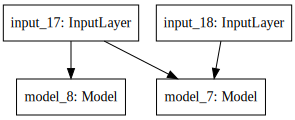

In [35]:
gan = GAN(gen,dis)
SVG(model_to_dot(gan).create(prog='dot', format='svg'))

In [36]:
gan.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_17 (InputLayer)            (None, 256, 256, 12)  0                                            
____________________________________________________________________________________________________
input_18 (InputLayer)            (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
model_8 (Model)                  (None, 256, 256, 3)   54432515    input_17[0][0]                   
____________________________________________________________________________________________________
model_7 (Model)                  (None, 1)             681682      input_17[0][0]                   
                                                                   input_18[0][0]          

In [37]:
train_img = train_d[0]
train_label = train_d[1]

In [38]:
gan_pre = gan.predict([train_label[0:10],train_img[0:10]])
print(gan_pre[1])

[[ 0.2867994 ]
 [ 0.29612279]
 [ 0.30135998]
 [ 0.28980705]
 [ 0.2958464 ]
 [ 0.28789598]
 [ 0.29606846]
 [ 0.29078692]
 [ 0.29592139]
 [ 0.29341123]]


In [39]:
gan_pre[0].shape

(10, 256, 256, 3)

In [85]:
import tensorflow as tf
sess = K.get_session()
y_true = tf.Variable(np.array([0.0,1.0]))
y_pred = tf.Variable(gan_pre[1].astype(np.float64).reshape(2))
init_run = tf.global_variables_initializer()
sess.run(init_run)
sess.run(K.binary_crossentropy(y_pred,y_true))

array([ 0.98424064,  0.47070626])

In [119]:
gen_pre = gen.predict([train_label])

In [44]:
sess = K.get_session()
y_true = train_img[0:10]
y_pred = gan_pre[0]
loss = K.mean(K.abs(y_pred - y_true))
sess.run(loss)

0.35076454

In [107]:
sess.run(K.mean(K.sum(K.abs(train_img - gan_pre[0]), axis=[1,2,3])))

77424.375

In [111]:
np.abs(train_img - gan_pre[0]).shape

(2, 256, 256, 3)

In [118]:
np.mean(np.sum(np.sum(np.sum(np.abs(train_img - gan_pre[0]),axis=1),axis=1),axis=1))

77424.312